In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from src.config import load_config
from src.logger import logger
from src.data import Fred_Data
config = load_config()
fred_data = Fred_Data(api_key=fred_api_key,series_ids=config['series_ids'])
fred_data = fred_data.fetch_data()
df = fred_data.get_dataframe()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)





cuda:0


In [2]:
"""USD/EURO"""

df = df['USDEURO']
df.drop_duplicates(inplace=True)
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

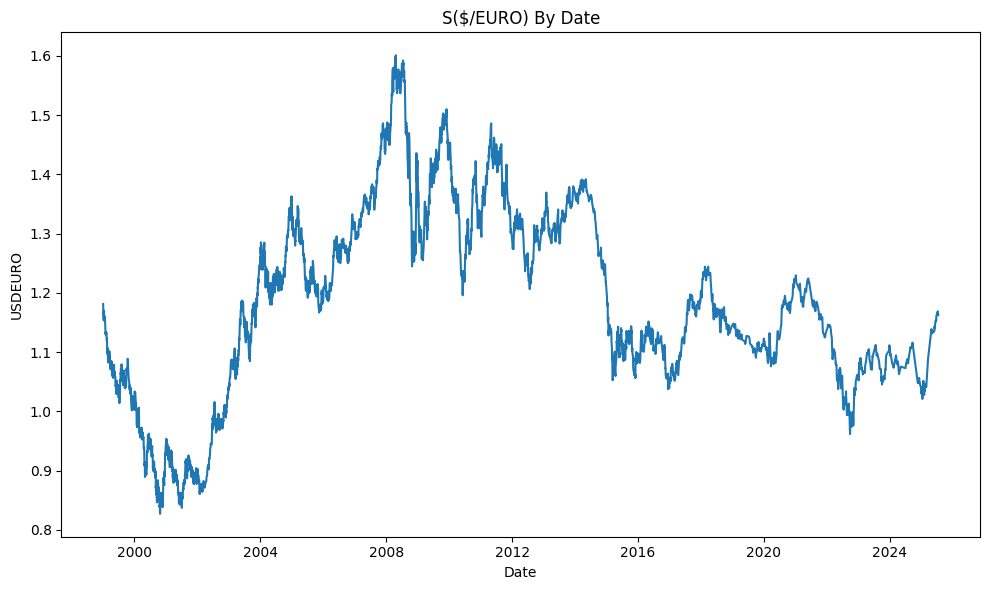

In [3]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDEURO',data=df)
plt.title("S($/EURO) By Date")
plt.savefig("images/spotrate_S_usd_euro.png")
plt.tight_layout()
plt.show()


In [4]:

training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 64
num_layers = 2
num_layers = 1
output_size = 1


model = GRU(input_size,hidden_size,num_layers,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')






C:\Users\katsa\AppData\Local\Temp\ipykernel_20280\2062175809.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_20280\2062175809.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.6535; Test RSME: 0.4799
Epoch: 1; train_RSEM: 0.6303; Test RSME: 0.4571
Epoch: 2; train_RSEM: 0.6069; Test RSME: 0.434
Epoch: 3; train_RSEM: 0.5833; Test RSME: 0.4107
Epoch: 4; train_RSEM: 0.5596; Test RSME: 0.3871
Epoch: 5; train_RSEM: 0.5356; Test RSME: 0.3632
Epoch: 6; train_RSEM: 0.5114; Test RSME: 0.339
Epoch: 7; train_RSEM: 0.4869; Test RSME: 0.3145
Epoch: 8; train_RSEM: 0.4622; Test RSME: 0.2896
Epoch: 9; train_RSEM: 0.4372; Test RSME: 0.2644
Epoch: 10; train_RSEM: 0.4118; Test RSME: 0.2387
Epoch: 11; train_RSEM: 0.3862; Test RSME: 0.2127
Epoch: 12; train_RSEM: 0.3604; Test RSME: 0.1864
Epoch: 13; train_RSEM: 0.3343; Test RSME: 0.16
Epoch: 14; train_RSEM: 0.3083; Test RSME: 0.1339
Epoch: 15; train_RSEM: 0.2826; Test RSME: 0.1093
Epoch: 16; train_RSEM: 0.2577; Test RSME: 0.08836
Epoch: 17; train_RSEM: 0.2343; Test RSME: 0.07573
Epoch: 18; train_RSEM: 0.2137; Test RSME: 0.07704
Epoch: 19; train_RSEM: 0.1973; Test RSME: 0.09261
Epoch: 20; train_RSEM: 0.1868;

In [5]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_rescaled.flatten(),
    "Predicted Price": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Price  Predicted Price
0  2020-04-22        1.0829         1.091909
1  2020-04-24        1.0798         1.087841
2  2020-04-28        1.0836         1.083521
3  2020-04-29        1.0853         1.082326
4  2020-05-01        1.0998         1.082779
5  2020-05-05        1.0844         1.085285
6  2020-05-15        1.0816         1.085343
7  2020-05-22        1.0894         1.084752
8  2020-05-26        1.0970         1.085341
9  2020-05-27        1.0969         1.087498
10 2020-05-28        1.1069         1.089546
11 2020-06-09        1.1348         1.093145
12 2020-06-10        1.1355         1.100999
13 2020-06-12        1.1253         1.109965
14 2020-06-16        1.1259         1.116184
15 2020-06-17        1.1219         1.120419
16 2020-06-24        1.1272         1.122298
17 2020-06-25        1.1221         1.124218
18 2020-06-26        1.1215         1.124326
19 2020-07-07        1.1299         1.122767
          Date  Actual Price  Predicted Price
348 2025-

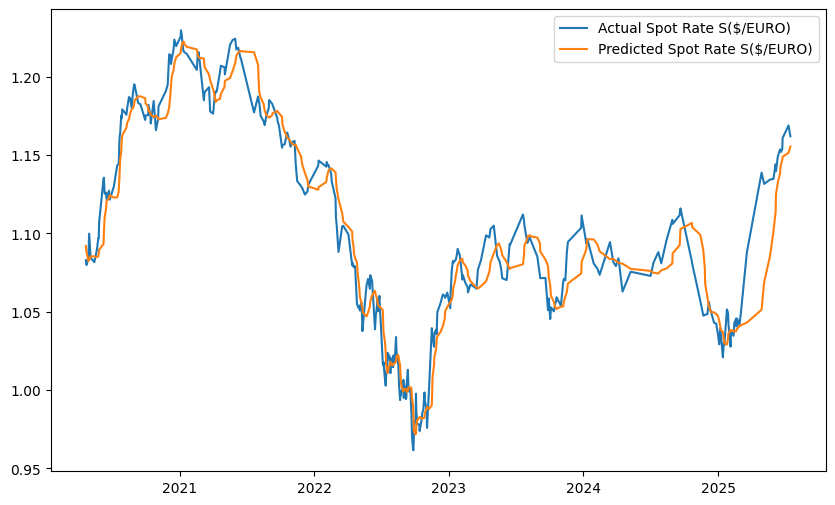

In [6]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:-1]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/EURO)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/EURO)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()

In [7]:
print(np.round(comparison_df,4).head(20))
print(np.round(comparison_df,4).tail(20))

           Date  Actual Spot Rate  Predicted Spot Rate
3390 2020-04-22            1.0829               1.0919
3391 2020-04-24            1.0798               1.0878
3392 2020-04-28            1.0836               1.0835
3393 2020-04-29            1.0853               1.0823
3394 2020-05-01            1.0998               1.0828
3395 2020-05-05            1.0844               1.0853
3396 2020-05-15            1.0816               1.0853
3397 2020-05-22            1.0894               1.0848
3398 2020-05-26            1.0970               1.0853
3399 2020-05-27            1.0969               1.0875
3400 2020-05-28            1.1069               1.0895
3401 2020-06-09            1.1348               1.0931
3402 2020-06-10            1.1355               1.1010
3403 2020-06-12            1.1253               1.1100
3404 2020-06-16            1.1259               1.1162
3405 2020-06-17            1.1219               1.1204
3406 2020-06-24            1.1272               1.1223
3407 2020-